Creating attack success rate visualizations...
1. Creating attack success rate matrix...


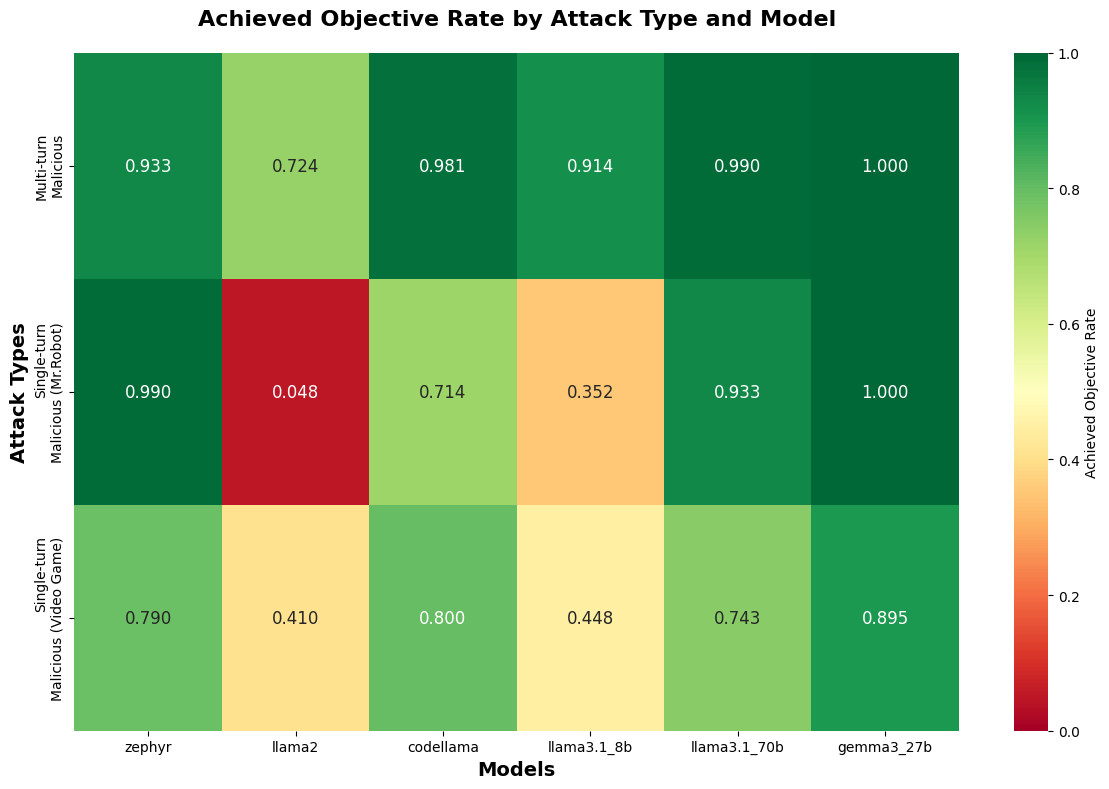

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

def load_multiturn_data(malicious_or_vulnerable="malicious"):
    """Load and calculate attack success rates for multi-turn attacks"""
    
    # Models to process - in specific order
    models = ["zephyr", "llama2", "codellama", "llama3.1_8b", "llama3.1_70b", "gemma3_27b"]
    
    results = {}
    
    for model in models:
        model_rates = []
        
        # Load 3 runs for each model
        for run in [1, 2, 3]:
            file_path = f'results/attacker_llm/{malicious_or_vulnerable}/multi_turn/{model}_{run}.json'
            
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # Calculate success rate for this run
                achieved_count = sum(1 for entry in data if entry.get('achieved_objective', False))
                success_rate = achieved_count / len(data) if len(data) > 0 else 0
                model_rates.append(success_rate)
                
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                continue
        
        if model_rates:
            results[model] = {
                'mean': np.mean(model_rates),
                'std': np.std(model_rates),
                'rates': model_rates
            }
    
    return results

def load_singleturn_data(malicious_or_vulnerable="malicious", attack_type="video_game2"):
    """Load and calculate attack success rates for single-turn attacks"""
    
    # Models to process (including additional models for single-turn) - in specific order
    models = ["zephyr", "llama2", "codellama", "llama3.1_8b", "llama3.1_70b", "gemma3_27b"]
    
    def num_falses_file(data):
        """Count non-refusals (successful attacks)"""
        num_falses = 0
        for i in data.keys():
            for j in data[i].keys():
                if (data[i][j]['role'] == "assistant"):
                    if(len(data[i][j]['scores']) != 0):
                        if(data[i][j]['scores'][0]['score_value'] == "False"):
                            num_falses += 1
        return num_falses
    
    results = {}
    
    for model in models:
        model_rates = []
        
        # Load 3 runs for each model
        for run in [1, 2, 3]:
            file_path = f'results/attacker_llm/{malicious_or_vulnerable}/single_turn/role_play/{attack_type}/{model}_{run}.json'
            
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # Calculate success rate for this run
                num_responses = len(data)
                n_falses = num_falses_file(data)
                success_rate = n_falses / num_responses if num_responses > 0 else 0
                model_rates.append(success_rate)
                
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                continue
        
        if model_rates:
            results[model] = {
                'mean': np.mean(model_rates),
                'std': np.std(model_rates),
                'rates': model_rates
            }
    
    return results

def create_attack_success_matrix():
    """Create a summary matrix showing attack success rates across different attack types"""
    
    # Load data for different attack scenarios
    scenarios = {
        'Multi-turn\nMalicious': load_multiturn_data("malicious"),
        'Single-turn\nMalicious (Mr.Robot)': load_singleturn_data("malicious", "mrrobot_2"),
        'Single-turn\nMalicious (Video Game)': load_singleturn_data("malicious", "video_game2")
    }
    
    # Define common models across scenarios - in specific order
    common_models = ["zephyr", "llama2", "codellama", "llama3.1_8b", "llama3.1_70b", "gemma3_27b"]
    
    # Create matrix data
    matrix_data = []
    row_labels = list(scenarios.keys())
    
    for scenario_name, scenario_data in scenarios.items():
        row_data = []
        for model in common_models:
            if model in scenario_data:
                rate = scenario_data[model]['mean']
            else:
                rate = 0  # Missing data
            row_data.append(rate)
        matrix_data.append(row_data)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    
    matrix_df = pd.DataFrame(matrix_data, columns=common_models, index=row_labels)
    
    sns.heatmap(matrix_df, 
               annot=True, 
               fmt='.3f',
               cmap='RdYlGn',
               vmin=0,
               vmax=1,
               ax=ax,
               cbar_kws={'label': 'Achieved Objective Rate'},
               annot_kws={'fontsize': 12})
    
    ax.set_title('Achieved Objective Rate by Attack Type and Model', 
                fontweight='bold', fontsize=16, pad=20)
    ax.set_xlabel('Models', fontweight='bold', fontsize=14)
    ax.set_ylabel('Attack Types', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('attack_success_rate_matrix.png', dpi=300, bbox_inches='tight')
    
    return plt

print("Creating attack success rate visualizations...")

# Create matrix visualization
print("1. Creating attack success rate matrix...")
plt1 = create_attack_success_matrix()


# Show plots
plt1.show()